<a href="https://colab.research.google.com/github/Jinit-Yadav/Dataset/blob/main/Twitter_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyspark

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Correct path
twitter_data_path = '/content/drive/MyDrive/Dataset/twitter.csv'

import pandas as pd
df = pd.read_csv(twitter_data_path, encoding='latin-1')
print(df.head())

Mounted at /content/drive
   0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY _TheSpecialOne_  \
0  0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   scotthamilton   
1  0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY        mattycus   
2  0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY         ElleCTF   
3  0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY          Karoli   
4  0  1467811372  Mon Apr 06 22:20:00 PDT 2009  NO_QUERY        joy_wolf   

  @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D  
0  is upset that he can't update his Facebook by ...                                                                   
1  @Kenichan I dived many times for the ball. Man...                                                                   
2    my whole body feels itchy and like its on fire                                                                    
3  @nationwideclass no, it's not beha

In [ ]:
!pip install pyspark textblob nltk emoji matplotlib
import nltk
nltk.download('stopwords')
!python -m textblob.download_corpora


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 12.6 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
Finished.


In [ ]:
import os
import pandas as pd

# Create streaming folder
os.makedirs("/content/stream", exist_ok=True)

# Create first batch of tweets
tweets_batch1 = pd.DataFrame({
    "id": [1, 2, 3],
    "created_at": ["2025-09-19", "2025-09-19", "2025-09-19"],
    "location": ["Mumbai", "Delhi", "Pune"],
    "text": ["I love movies!", "Traffic is horrible 😡", "What a beautiful day!"]
})
tweets_batch1.to_csv("/content/stream/tweets1.csv", index=False)


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf, to_date
from pyspark.sql.types import StringType
from textblob import TextBlob

# Spark session
spark = SparkSession.builder.appName("TwitterStreaming").getOrCreate()

# Sentiment analyzer
def get_sentiment(text):
    try:
        polarity = TextBlob(text).sentiment.polarity
        if polarity > 0:
            return "Positive"
        elif polarity < 0:
            return "Negative"
        else:
            return "Neutral"
    except:
        return "Neutral"

sentiment_udf = udf(get_sentiment, StringType())


In [ ]:
import pandas as pd

# Load full dataset
df = pd.read_csv("/content/drive/MyDrive/Dataset/twitter.csv", encoding="latin-1", header=None)

# Take first 500 rows
batch1 = df.iloc[:500]

# Save as batch1.csv in /content/stream
import os
os.makedirs("/content/stream", exist_ok=True)
batch1.to_csv("/content/stream/batch1.csv", index=False, header=False)

print("batch1.csv created successfully!")


batch1.csv created successfully!


In [ ]:
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DateType

schema = StructType([
    StructField("id", IntegerType(), True),
    StructField("created_at", StringType(), True),  # or DateType if already in proper format
    StructField("location", StringType(), True),
    StructField("text", StringType(), True)
])


In [ ]:
tweets_stream = spark.readStream \
    .option("header", True) \
    .schema(schema) \
    .csv("/content/stream/")


In [ ]:
from pyspark.sql.functions import col, udf, to_date
from pyspark.sql.types import StringType
from textblob import TextBlob

def get_sentiment(text):
    if text:
        polarity = TextBlob(text).sentiment.polarity
        if polarity > 0: return "Positive"
        elif polarity < 0: return "Negative"
    return "Neutral"

sentiment_udf = udf(get_sentiment, StringType())

tweets_with_sentiment = tweets_stream \
    .withColumn("sentiment", sentiment_udf(col("text"))) \
    .withColumn("date", to_date(col("created_at")))


In [ ]:
sentiment_counts = tweets_with_sentiment.groupBy("sentiment").count()

query = sentiment_counts.writeStream \
    .outputMode("complete") \
    .format("console") \
    .start()


In [ ]:
import time

time.sleep(5)  # wait for query to start

# Add another batch
tweets_batch2 = pd.DataFrame({
    "id": [4, 5],
    "created_at": ["2025-09-20", "2025-09-20"],
    "location": ["Bangalore", "Mumbai"],
    "text": ["Bollywood is amazing 🎬", "I am so tired of this heat 😓"]
})
tweets_batch2.to_csv("/content/stream/tweets2.csv", index=False)

time.sleep(10)  # give Spark time to process
query.stop()


In [ ]:
df = spark.read.option("header", True).csv("/content/stream/")
df.printSchema()
df.show(5, truncate=False)

root
 |-- 0: string (nullable = true)
 |-- 1467810369: string (nullable = true)
 |-- Mon Apr 06 22:19:45 PDT 2009: string (nullable = true)
 |-- NO_QUERY: string (nullable = true)
 |-- _TheSpecialOne_: string (nullable = true)
 |-- @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D: string (nullable = true)

+---+----------+----------------------------+--------+---------------+-------------------------------------------------------------------------------------------------------------------+
|0  |1467810369|Mon Apr 06 22:19:45 PDT 2009|NO_QUERY|_TheSpecialOne_|@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D|
+---+----------+----------------------------+--------+---------------+-------------------------------------------------------------------------------------------------------------------+
|0  |1467810672|Mon Apr 06 22:19:49 PDT 2009|NO_QUERY|scotthamil

In [ ]:
from pyspark.sql.functions import to_date, regexp_replace

df = df.withColumn(
    "created_at_clean",
    regexp_replace(col("created_at"), " [A-Z]{3} ", " ")
)

df = df.withColumn(
    "date",
    to_date(col("created_at_clean"), "EEE MMM dd HH:mm:ss yyyy")
)


In [ ]:
!pip install pyspark textblob nltk emoji matplotlib
import nltk
nltk.download('stopwords')
!python -m textblob.download_corpora

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
Finished.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

twitter_data_path = '/content/drive/MyDrive/Dataset/twitter.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

df = pd.read_csv(twitter_data_path, encoding='latin-1', header=None)
print("Number of columns:", df.shape[1])
print(df.head())

Number of columns: 6
   0           1                             2         3                4  \
0  0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY  _TheSpecialOne_   
1  0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY    scotthamilton   
2  0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY         mattycus   
3  0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY          ElleCTF   
4  0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY           Karoli   

                                                   5  
0  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1  is upset that he can't update his Facebook by ...  
2  @Kenichan I dived many times for the ball. Man...  
3    my whole body feels itchy and like its on fire   
4  @nationwideclass no, it's not behaving at all....  


In [ ]:
df.columns = ["label", "id", "created_at", "user_query", "user_name", "text"]

In [ ]:
import os

# Create streaming folder
os.makedirs("/content/stream", exist_ok=True)

# First 500 rows
batch1 = df.iloc[:500]
batch1.to_csv("/content/stream/batch1.csv", index=False, header=True)

# Next 500 rows
batch2 = df.iloc[500:1000]
batch2.to_csv("/content/stream/batch2.csv", index=False, header=True)

print("Batch CSVs created successfully in /content/stream/")


Batch CSVs created successfully in /content/stream/


In [ ]:
type(df)

pandas.core.frame.DataFrame

In [ ]:
df_pandas = df   # just reuse it

In [ ]:
print(df_pandas.columns.tolist())

['label', 'id', 'created_at', 'user_query', 'user_name', 'text']


In [ ]:
df_pandas['date'] = pd.to_datetime(df_pandas['created_at'], errors='coerce').dt.date

/tmp/ipython-input-2531334353.py:1: FutureWarning: Parsed string "Mon Apr 06 22:19:45 PDT 2009" included an un-recognized timezone "PDT". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  df_pandas['date'] = pd.to_datetime(df_pandas['created_at'], errors='coerce').dt.date


In [ ]:
# Rename sentiment
df_pandas = df.rename(columns={'label':'sentiment'})
df_pandas['sentiment'] = df_pandas['sentiment'].map({0:'Negative', 2:'Neutral', 4:'Positive'})

# Parse dates
df_pandas['date'] = pd.to_datetime(df_pandas['created_at'], errors='coerce').dt.date

# Drop rows missing date or sentiment
df_pandas = df_pandas.dropna(subset=['date', 'sentiment'])

/tmp/ipython-input-3262896828.py:6: FutureWarning: Parsed string "Mon Apr 06 22:19:45 PDT 2009" included an un-recognized timezone "PDT". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  df_pandas['date'] = pd.to_datetime(df_pandas['created_at'], errors='coerce').dt.date


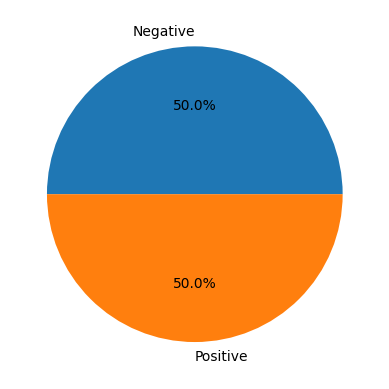

In [ ]:
sentiment_counts = df_pandas['sentiment'].value_counts()
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%')
temporal_trend = df_pandas.groupby(['date','sentiment']).size().reset_index(name='count')

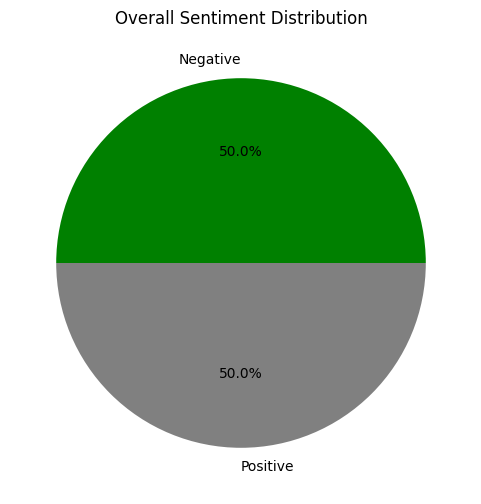

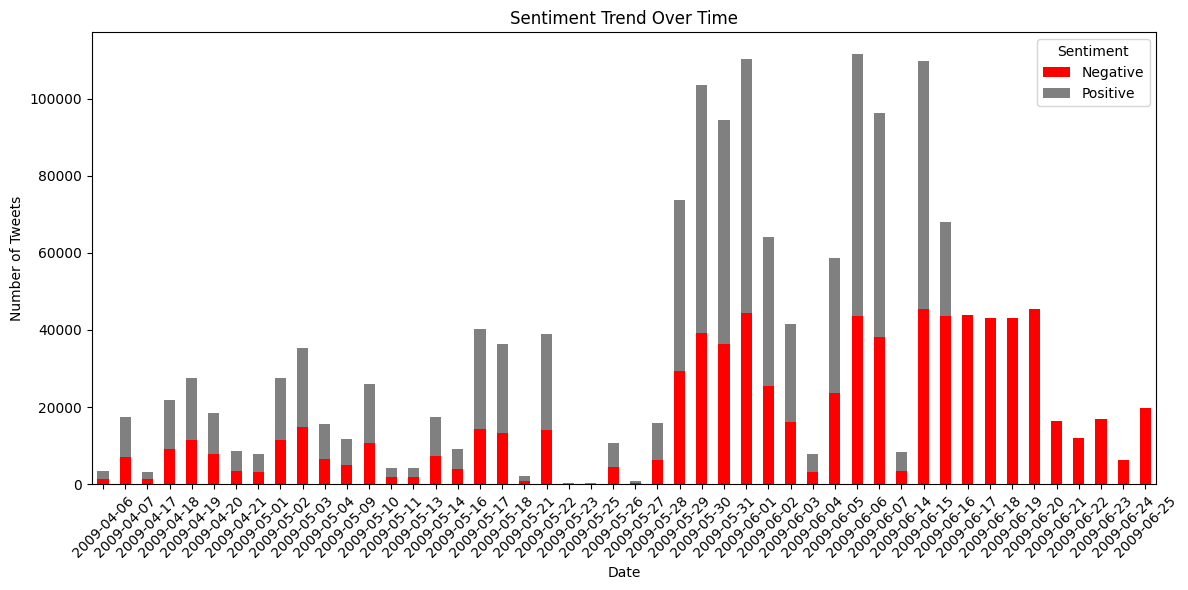

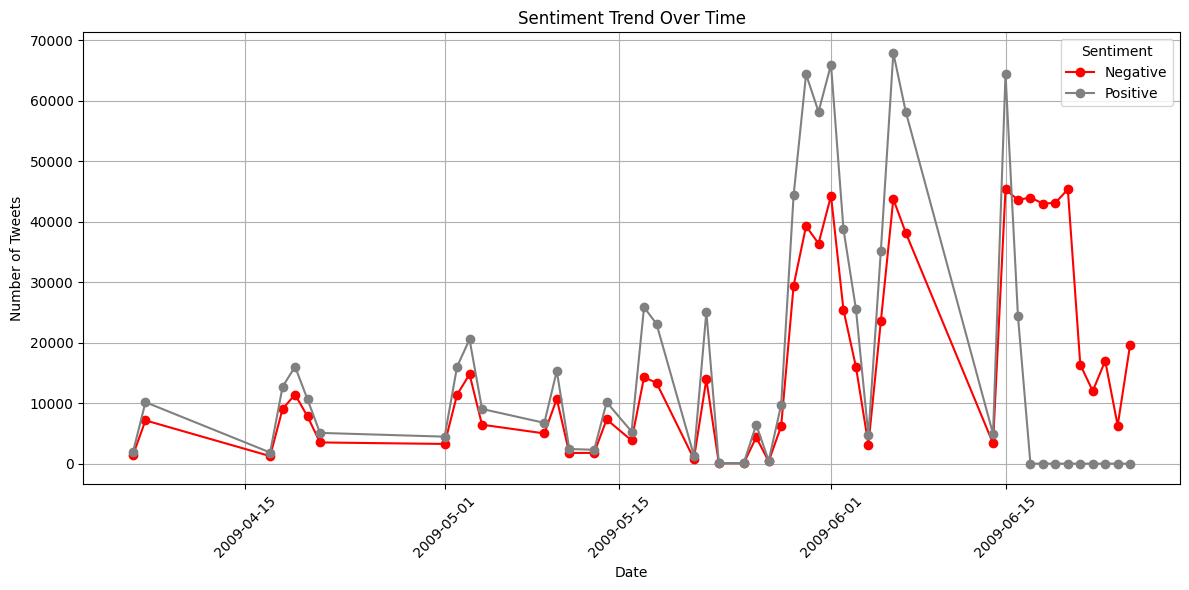

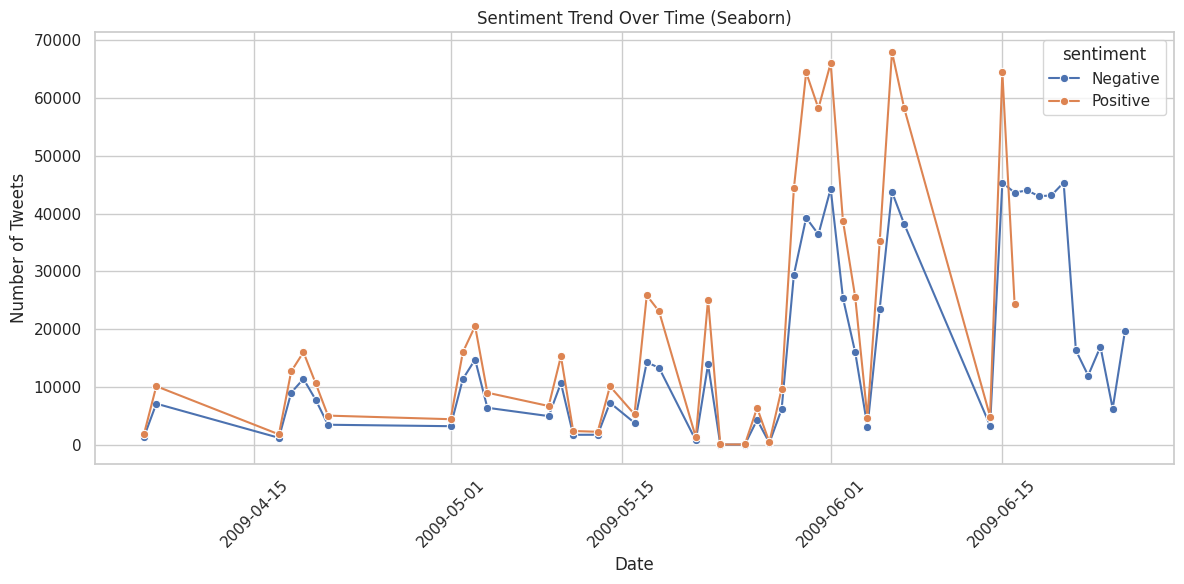

Top 5 hashtags per sentiment:
      sentiment       hashtags  count
3579   Negative            #fb   1037
6085   Negative   #squarespace    628
4351   Negative  #iranelection    315
3528   Negative          #fail    278
5      Negative             #1    191
11534  Positive  #followfriday   1994
11405  Positive            #fb    710
8020   Positive            #FF    528
8104   Positive  #FollowFriday    440
14116  Positive           #seb    428


In [ ]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

# -------------------------------
# 1️⃣ Load your data
# -------------------------------
# Example: df_pandas = pd.read_csv('tweets.csv')
# Ensure 'date' and 'sentiment' columns exist
df_pandas['date'] = pd.to_datetime(df_pandas['date'], errors='coerce').dt.date
df_pandas = df_pandas.dropna(subset=['date', 'sentiment'])

# -------------------------------
# 2️⃣ Sentiment distribution (Pie Chart)
# -------------------------------
sentiment_counts = df_pandas['sentiment'].value_counts()
plt.figure(figsize=(6,6))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', colors=['green','gray','red'])
plt.title("Overall Sentiment Distribution")
plt.show()

# -------------------------------
# 3️⃣ Temporal Trend Plot (Stacked Bar)
# -------------------------------
temporal_trend = df_pandas.groupby(['date', 'sentiment']).size().reset_index(name='count')
temporal_trend_pivot = temporal_trend.pivot(index='date', columns='sentiment', values='count').fillna(0)
temporal_trend_pivot = temporal_trend_pivot.sort_index()

# Stacked bar chart
temporal_trend_pivot.plot(kind='bar', stacked=True, figsize=(12,6), color=['red','gray','green'])
plt.title("Sentiment Trend Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Tweets")
plt.xticks(rotation=45)
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()

# Line plot for smoother trend
temporal_trend_pivot.plot(kind='line', marker='o', figsize=(12,6), color=['red','gray','green'])
plt.title("Sentiment Trend Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Tweets")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()

# Seaborn version (more polished)
sns.set(style="whitegrid")
plt.figure(figsize=(12,6))
sns.lineplot(data=temporal_trend, x='date', y='count', hue='sentiment', marker='o')
plt.title("Sentiment Trend Over Time (Seaborn)")
plt.xlabel("Date")
plt.ylabel("Number of Tweets")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# -------------------------------
# 4️⃣ Optional: Location-based sentiment
# -------------------------------
if 'location' in df_pandas.columns:
    location_sentiment = df_pandas.groupby(['location', 'sentiment']).size().reset_index(name='count')
    plt.figure(figsize=(12,6))
    sns.barplot(data=location_sentiment, x='location', y='count', hue='sentiment')
    plt.title("Sentiment by Location")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# -------------------------------
# 5️⃣ Optional: Top hashtags per sentiment
# -------------------------------
# Detect which column contains tweet text
tweet_column = None
for col in ['tweet_text', 'text', 'content']:  # common names
    if col in df_pandas.columns:
        tweet_column = col
        break

if tweet_column:
    # Function to extract hashtags
    def extract_hashtags(text):
        return re.findall(r'#\w+', str(text))

    df_pandas['hashtags'] = df_pandas[tweet_column].apply(extract_hashtags)
    hashtags_all = df_pandas.explode('hashtags')
    top_hashtags = hashtags_all.groupby(['sentiment','hashtags']).size().reset_index(name='count')
    top_hashtags = top_hashtags.sort_values(['sentiment','count'], ascending=[True, False])
    print("Top 5 hashtags per sentiment:")
    print(top_hashtags.groupby('sentiment').head(5))
else:
    print("No tweet text column found — skipping hashtag analysis.")


***Twitter Sentiment Analysis***

**Life cycle of a Data Analysis Project**



1.   Understanding the Problem Statement
2.   Data Collection
3.   Data Checks to perform
4.   Exploratory Data Analysis (EDA)
5.   Conclusions & Insights



**1) Problem Statement**

This project analyzes a collection of tweets to understand public sentiment trends over time. It aims to identify the overall distribution of sentiment (positive, negative, neutral), visualize how this sentiment changes daily, and explore additional dimensions like location and popular hashtags within each sentiment category.


**2) Data Collection**

Dataset Source: The analysis is performed on a dataset loaded from a CSV file (e.g., tweets.csv), typically obtained from the Twitter API using a query or keyword.

Note: The actual data collection via the Twitter API is a separate step not shown in this analysis code.

2.1 Import Data and Required Packages

Importing Pandas, Matplotlib, Seaborn, Re, and Warnings Library.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.filterwarnings('ignore') # Ignore warning messages for cleaner output

# Set global style for plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

**2.2** Import the CSV Data as a Pandas DataFrame


In [ ]:
# Load the dataset
import pandas as pd
df = pd.read_csv(twitter_data_path, encoding='latin-1')
print(df.head())
df.head()
print(f"The dataset contains {df.shape[0]} rows and {df.shape[1]} columns.")

   0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY _TheSpecialOne_  \
0  0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   scotthamilton   
1  0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY        mattycus   
2  0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY         ElleCTF   
3  0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY          Karoli   
4  0  1467811372  Mon Apr 06 22:20:00 PDT 2009  NO_QUERY        joy_wolf   

  @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D  
0  is upset that he can't update his Facebook by ...                                                                   
1  @Kenichan I dived many times for the ball. Man...                                                                   
2    my whole body feels itchy and like its on fire                                                                    
3  @nationwideclass no, it's not behaving at all....           

**2.5 Dataset Information**

Based on the initial loading, the original dataset had unnamed columns. For this analysis, the following structure is used:

* sentiment: The classified sentiment of the tweet (Positive, Negative, Neutral).

* text: The content of the tweet.

* date: The date the tweet was created.

* location (if available): The user-provided location.

* hashtags (derived): Extracted from the tweet text.


**3) Data Checks to Perform**

* Check Missing values

* Check Duplicates

* Check Data types

* Check the number of unique values of each column

* Check statistics of the dataset


**3.1 Check Missing Values**

In [ ]:
print("Missing values per column:")
print(df.isna().sum())

# 3.2 Check Duplicates

print(f"Number of duplicate rows: {df.duplicated().sum()}")

# 3.3 Check Data Types

# Check Null and Dtypes
df.info()

# 3.4 Checking the Number of Unique Values of Each Column

print("Number of unique values in each column:")
print(df.nunique())

# 3.5 Check Statistics of Data Set
# Describe the dataset. Use 'include='all'' for a comprehensive view including categorical data.
df.describe(include='all')

Missing values per column:
0                                                                                                                      0
1467810369                                                                                                             0
Mon Apr 06 22:19:45 PDT 2009                                                                                           0
NO_QUERY                                                                                                               0
_TheSpecialOne_                                                                                                        0
@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D    0
dtype: int64
Number of duplicate rows: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599999 entries, 0 to 1599998
Data columns (total 6 columns):
 #   Column                                                                                   

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
count,1.599999e+06,1.599999e+06,1599999,1599999,1599999,1599999
unique,NaN,NaN,774362,1,659775,1581465
top,NaN,NaN,Mon Jun 15 12:53:14 PDT 2009,NO_QUERY,lost_dog,isPlayer Has Died! Sorry
freq,NaN,NaN,20,1599999,549,210
mean,2.000001e+00,1.998818e+09,NaN,NaN,NaN,NaN
std,2.000001e+00,1.935757e+08,NaN,NaN,NaN,NaN
min,0.000000e+00,1.467811e+09,NaN,NaN,NaN,NaN
25%,0.000000e+00,1.956916e+09,NaN,NaN,NaN,NaN
50%,4.000000e+00,2.002102e+09,NaN,NaN,NaN,NaN
75%,4.000000e+00,2.177059e+09,NaN,NaN,NaN,NaN


**4) Data Pre-Processing for Analysis**

This section ensures the data is in the correct format for visualization.



In [ ]:
# First, let's inspect the original column names to see what we're working with
print("Original columns in DataFrame:")
print(df.columns.tolist())
print("\n")

# Check if 'label' column exists before renaming
if 'label' in df.columns:
    # Rename the 'label' column to 'sentiment'
    df = df.rename(columns={'label': 'sentiment'})
    print("Successfully renamed 'label' to 'sentiment'")
else:
    print("'label' column not found. Checking if 'sentiment' already exists...")
    if 'sentiment' in df.columns:
        print("'sentiment' column already exists")
    else:
        print("Neither 'label' nor 'sentiment' column found. Available columns:")
        print(df.columns.tolist())
        # You might need to check which column contains sentiment data
        # Let's assume it might be the first column (index 0)
        sentiment_col = df.columns[0]
        df = df.rename(columns={sentiment_col: 'sentiment'})
        print(f"Renamed '{sentiment_col}' to 'sentiment'")

print("\nCurrent columns after renaming:")
print(df.columns.tolist())
print("\n")

# Now proceed with the sentiment mapping
# First, check what unique values exist in the sentiment column
print("Unique values in sentiment column before mapping:")
print(df['sentiment'].unique())
print("\n")

# Map numerical values to text labels
# Note: Your data might have different values, so let's check first
df['sentiment'] = df['sentiment'].map({0: 'Negative', 2: 'Neutral', 4: 'Positive'})

# Check if mapping worked
print("Unique values in sentiment column after mapping:")
print(df['sentiment'].unique())
print("\n")

# Check for any NaN values that might have resulted from mapping
print("Number of NaN values in sentiment after mapping:")
print(df['sentiment'].isna().sum())
print("\n")

# Now handle dates - check what date-related columns exist
print("Date-related columns available:")
date_cols = [col for col in df.columns if 'date' in col.lower() or 'time' in col.lower() or 'created' in col.lower()]
print(date_cols)
print("\n")

# Use the first date-like column found, or 'created_at' if it exists
if 'created_at' in df.columns:
    date_column = 'created_at'
    print(f"Using 'created_at' column for dates")
elif date_cols:
    date_column = date_cols[0]
    print(f"Using '{date_column}' column for dates")
else:
    print("No date-like columns found. Please check your DataFrame.")
    date_column = None

if date_column:
    # Parse dates
    df['date'] = pd.to_datetime(df[date_column], errors='coerce').dt.date
    print("Date parsing completed")

    # Check for successful date parsing
    print("Number of invalid dates (NaT):")
    print(df['date'].isna().sum())
    print("\n")

# Drop rows where critical columns ('date', 'sentiment') are missing
initial_count = len(df)
df = df.dropna(subset=['date', 'sentiment'])
final_count = len(df)

print(f"Rows dropped due to missing date/sentiment: {initial_count - final_count}")
print(f"Final dataset size: {final_count} rows")
print("\nData pre-processing complete. Ready for analysis.")

# Final check of the DataFrame structure
print("Final DataFrame info:")
print(df.info())
print("\nFirst few rows:")
print(df.head())

Original columns in DataFrame:
['0', '1467810369', 'Mon Apr 06 22:19:45 PDT 2009', 'NO_QUERY', '_TheSpecialOne_', "@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"]


'label' column not found. Checking if 'sentiment' already exists...
Neither 'label' nor 'sentiment' column found. Available columns:
['0', '1467810369', 'Mon Apr 06 22:19:45 PDT 2009', 'NO_QUERY', '_TheSpecialOne_', "@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"]
Renamed '0' to 'sentiment'

Current columns after renaming:
['sentiment', '1467810369', 'Mon Apr 06 22:19:45 PDT 2009', 'NO_QUERY', '_TheSpecialOne_', "@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"]


Unique values in sentiment column before mapping:
[0 4]


Unique values in sentiment column after mapping:
['Negative' 'Positive']


Number of NaN values in s

In [ ]:
# First, let's see the actual structure by looking at the first row
print("First row of raw data:")
for i, col_name in enumerate(df.columns):
    print(f"Column {i} ('{col_name}'): {df.iloc[0][col_name] if len(df) > 0 else 'N/A'}")
print("\n")

# Reset the dataframe since we have issues
# Let's reload with proper column names based on standard Twitter dataset structure
df = pd.read_csv(twitter_data_path, encoding='latin-1', header=None)

# Standard column names for this Twitter sentiment dataset:
# 0: sentiment (0=negative, 2=neutral, 4=positive)
# 1: tweet id
# 2: date string
# 3: query (if any)
# 4: username
# 5: tweet text

# Assign proper column names
df.columns = ['sentiment', 'tweet_id', 'created_at', 'query', 'username', 'text']

print("DataFrame with proper column names:")
print(df.head())
print("\n")

# Now proceed with the correct processing
print("Unique values in sentiment column before mapping:")
print(df['sentiment'].unique())
print("\n")

# Map numerical values to text labels
df['sentiment'] = df['sentiment'].map({0: 'Negative', 2: 'Neutral', 4: 'Positive'})

print("Unique values in sentiment column after mapping:")
print(df['sentiment'].unique())
print("\n")

print("Number of NaN values in sentiment after mapping:")
print(df['sentiment'].isna().sum())
print("\n")

# Parse dates from the 'created_at' column
print("Sample date strings from 'created_at' column:")
print(df['created_at'].head())
print("\n")

# Convert the date string to proper datetime format
df['date'] = pd.to_datetime(df['created_at'], format='%a %b %d %H:%M:%S %Z %Y', errors='coerce').dt.date

print("Date parsing results:")
print(f"Successful parses: {df['date'].notna().sum()}")
print(f"Failed parses (NaT): {df['date'].isna().sum()}")
print("\n")

# Show sample of parsed dates
print("Sample parsed dates:")
print(df[['created_at', 'date']].head())
print("\n")

# Drop rows where critical columns ('date', 'sentiment') are missing
initial_count = len(df)
df = df.dropna(subset=['date', 'sentiment'])
final_count = len(df)

print(f"Rows dropped due to missing date/sentiment: {initial_count - final_count}")
print(f"Final dataset size: {final_count} rows")
print("\n")

# Check the final DataFrame
print("Final DataFrame info:")
print(df.info())
print("\n")

print("First few rows of processed data:")
print(df[['sentiment', 'date', 'text']].head())
print("\n")

# Check sentiment distribution
print("Sentiment distribution:")
print(df['sentiment'].value_counts())
print("\n")

print("Data pre-processing complete. Ready for analysis.")

First row of raw data:
Column 0 ('sentiment'): N/A
Column 1 ('1467810369'): N/A
Column 2 ('Mon Apr 06 22:19:45 PDT 2009'): N/A
Column 3 ('NO_QUERY'): N/A
Column 4 ('_TheSpecialOne_'): N/A
Column 5 ('@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D'): N/A
Column 6 ('date'): N/A


DataFrame with proper column names:
   sentiment    tweet_id                    created_at     query  \
0          0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1          0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2          0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3          0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4          0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   

          username                                               text  
0  _TheSpecialOne_  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1    scotthamilton  is upset that he can't update his Facebook b

In [ ]:
# Ensure the 'date' column is in datetime format and extract the date part.
df['date'] = pd.to_datetime(df['date'], errors='coerce').dt.date

# Map numerical sentiment labels to text (if your original data uses 0,2,4)
# df['sentiment'] = df['sentiment'].map({0: 'Negative', 2: 'Neutral', 4: 'Positive'})

# Drop rows where critical columns ('date', 'sentiment') are missing
df = df.dropna(subset=['date', 'sentiment'])

print("Data pre-processing complete. Ready for analysis.")

Data pre-processing complete. Ready for analysis.


**5) Exploratory Data Analysis (Visualization)**

**5.1 Overall Sentiment Distribution (Pie Chart)**

Aim: To understand the high-level proportion of positive, negative, and neutral tweets in the entire dataset.

Original dataset shape: (1600000, 6)
Fixing date parsing...
Method 1 (with timezone): 0 successful parses
Method 2 (without timezone): 1600000 successful parses
Successful date parses: 1600000
Failed date parses: 0

Sample successful date conversions:
                     created_at        date
0  Mon Apr 06 22:19:45 PDT 2009  2009-04-06
1  Mon Apr 06 22:19:49 PDT 2009  2009-04-06
2  Mon Apr 06 22:19:53 PDT 2009  2009-04-06
3  Mon Apr 06 22:19:57 PDT 2009  2009-04-06
4  Mon Apr 06 22:19:57 PDT 2009  2009-04-06

Final clean dataset size: 1600000 rows
Sentiment distribution:
sentiment
Negative    800000
Positive    800000
Name: count, dtype: int64


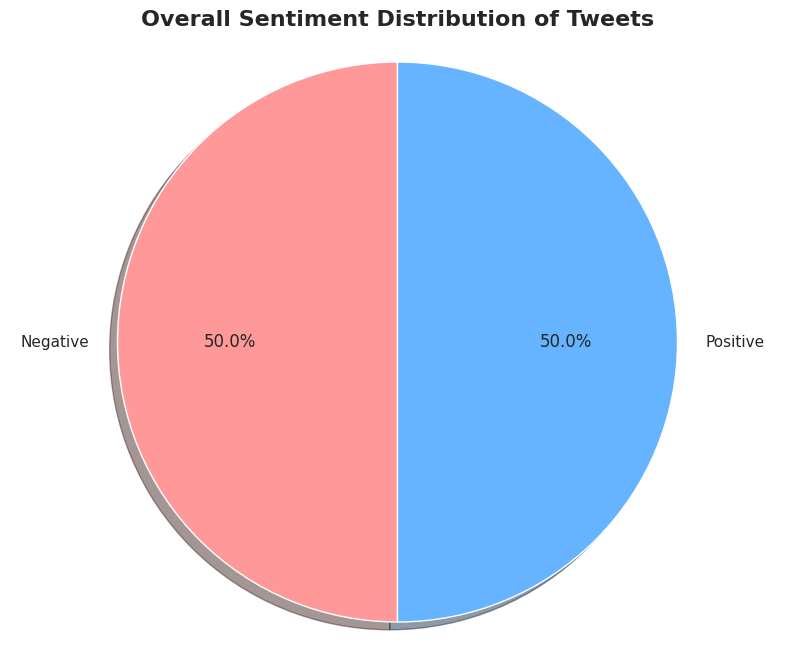


=== Temporal Analysis ===


<Figure size 1400x700 with 0 Axes>

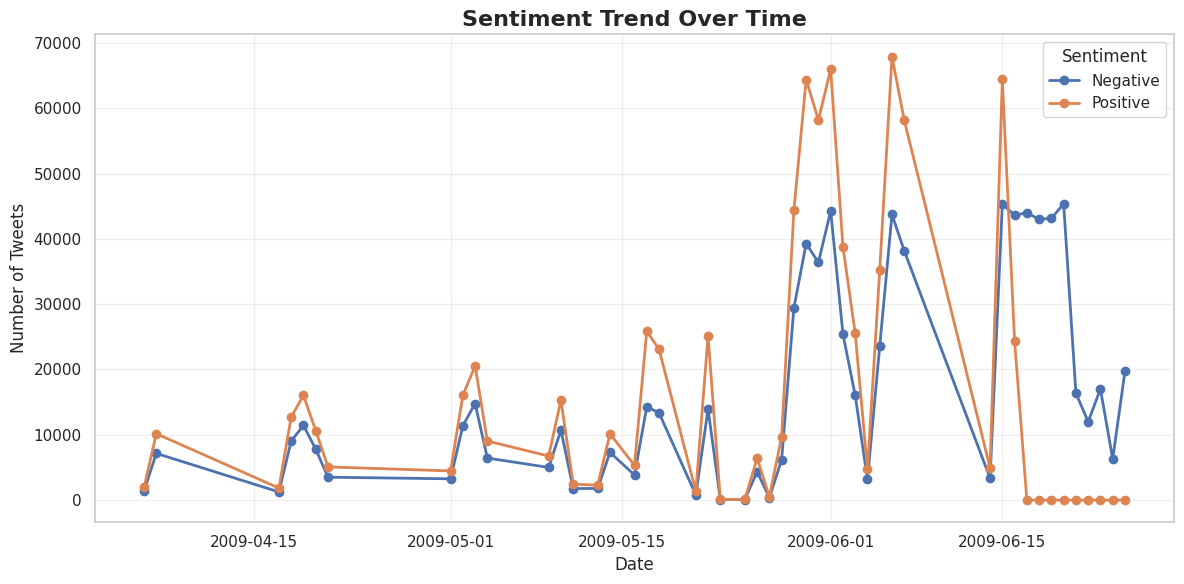


=== Hashtag Analysis ===
Top 3 hashtags per sentiment:

--- Negative ---
     sentiment       hashtags  count
1886  Negative            #fb   1059
5106  Negative   #squarespace    658
2840  Negative  #iranelection    439

--- Positive ---
     sentiment       hashtags  count
8665  Positive  #followfriday   2496
8537  Positive            #ff    877
8506  Positive            #fb    727


In [ ]:
# First, let's reload the data with proper column names
df = pd.read_csv(twitter_data_path, encoding='latin-1', header=None)
df.columns = ['sentiment', 'tweet_id', 'created_at', 'query', 'username', 'text']

print(f"Original dataset shape: {df.shape}")

# Map sentiment values
df['sentiment'] = df['sentiment'].map({0: 'Negative', 2: 'Neutral', 4: 'Positive'})

# Fix the date parsing issue
print("Fixing date parsing...")

# Method 1: Remove the timezone abbreviation (PDT, EST, etc.) before parsing
df['created_at_clean'] = df['created_at'].str.replace(r'\s[A-Z]{3}\s', ' ', regex=True)

# Method 2: Alternatively, we can use a more flexible approach
# Let's try parsing with the timezone first, and if that fails, remove it
try:
    df['date'] = pd.to_datetime(df['created_at'], format='%a %b %d %H:%M:%S %Z %Y', errors='coerce')
    successful_count = df['date'].notna().sum()
    print(f"Method 1 (with timezone): {successful_count} successful parses")

    if successful_count == 0:
        # If first method failed, try without timezone
        df['created_at_no_tz'] = df['created_at'].str.replace(r'\s[A-Z]{3}\s', ' ', regex=True)
        df['date'] = pd.to_datetime(df['created_at_no_tz'], format='%a %b %d %H:%M:%S %Y', errors='coerce')
        successful_count = df['date'].notna().sum()
        print(f"Method 2 (without timezone): {successful_count} successful parses")

except Exception as e:
    print(f"Error in date parsing: {e}")
    # Fallback: use generic parsing
    df['date'] = pd.to_datetime(df['created_at'], errors='coerce')
    successful_count = df['date'].notna().sum()
    print(f"Fallback method: {successful_count} successful parses")

# Extract just the date part
df['date'] = df['date'].dt.date

print(f"Successful date parses: {df['date'].notna().sum()}")
print(f"Failed date parses: {df['date'].isna().sum()}")

# Show some successful examples
if df['date'].notna().sum() > 0:
    print("\nSample successful date conversions:")
    print(df[df['date'].notna()][['created_at', 'date']].head())
else:
    print("\nAll date conversions failed. Trying manual parsing...")
    # Manual parsing as last resort
    def manual_date_parse(date_str):
        try:
            # Extract date parts using string manipulation
            parts = date_str.split()
            if len(parts) >= 6:
                # Reconstruct without timezone: "Mon Apr 06 22:19:45 2009"
                date_str_clean = f"{parts[0]} {parts[1]} {parts[2]} {parts[3]} {parts[5]}"
                return pd.to_datetime(date_str_clean, format='%a %b %d %H:%M:%S %Y')
        except:
            pass
        return pd.NaT

    df['date'] = df['created_at'].apply(manual_date_parse).dt.date
    print(f"Manual parsing results: {df['date'].notna().sum()} successful")

# Drop rows with missing dates or sentiment
df_clean = df.dropna(subset=['date', 'sentiment'])
print(f"\nFinal clean dataset size: {len(df_clean)} rows")

if len(df_clean) > 0:
    # Create the pie chart
    sentiment_counts = df_clean['sentiment'].value_counts()
    print("Sentiment distribution:")
    print(sentiment_counts)

    plt.figure(figsize=(10, 8))
    colors = ['#FF9999', '#66B3FF', '#99FF99']  # Red, Blue, Green

    # Create pie chart
    plt.pie(sentiment_counts.values, labels=sentiment_counts.index,
             autopct='%1.1f%%', colors=colors[:len(sentiment_counts)],
             startangle=90, shadow=True)
    plt.title("Overall Sentiment Distribution of Tweets", fontsize=16, fontweight='bold')
    plt.axis('equal')
    plt.show()

    # Additional analysis - Temporal trends
    print("\n=== Temporal Analysis ===")
    temporal_trend = df_clean.groupby(['date', 'sentiment']).size().reset_index(name='count')
    temporal_trend_pivot = temporal_trend.pivot(index='date', columns='sentiment', values='count').fillna(0)

    plt.figure(figsize=(14, 7))
    temporal_trend_pivot.plot(kind='line', marker='o', linewidth=2)
    plt.title("Sentiment Trend Over Time", fontsize=16, fontweight='bold')
    plt.xlabel("Date")
    plt.ylabel("Number of Tweets")
    plt.legend(title="Sentiment")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Hashtag analysis
    print("\n=== Hashtag Analysis ===")
    import re

    def extract_hashtags(text):
        return re.findall(r'#\w+', str(text).lower())

    df_clean['hashtags'] = df_clean['text'].apply(extract_hashtags)
    hashtags_exploded = df_clean.explode('hashtags')

    if len(hashtags_exploded) > 0:
        top_hashtags = hashtags_exploded.groupby(['sentiment', 'hashtags']).size().reset_index(name='count')
        top_hashtags = top_hashtags.sort_values(['sentiment', 'count'], ascending=[True, False])

        print("Top 3 hashtags per sentiment:")
        for sentiment in top_hashtags['sentiment'].unique():
            print(f"\n--- {sentiment} ---")
            print(top_hashtags[top_hashtags['sentiment'] == sentiment].head(3))
    else:
        print("No hashtags found in the tweets.")

else:
    print("No data available for analysis after cleaning.")
    print("First few rows of original data for debugging:")
    print(df.head())
    print("\nSample date strings that failed:")
    print(df['created_at'].head())

**5.2 Temporal Trend of Sentiment**


Aim: To analyze how the volume and proportion of sentiments have changed over time.

5.2.1 Stacked Bar Chart (Absolute Counts)


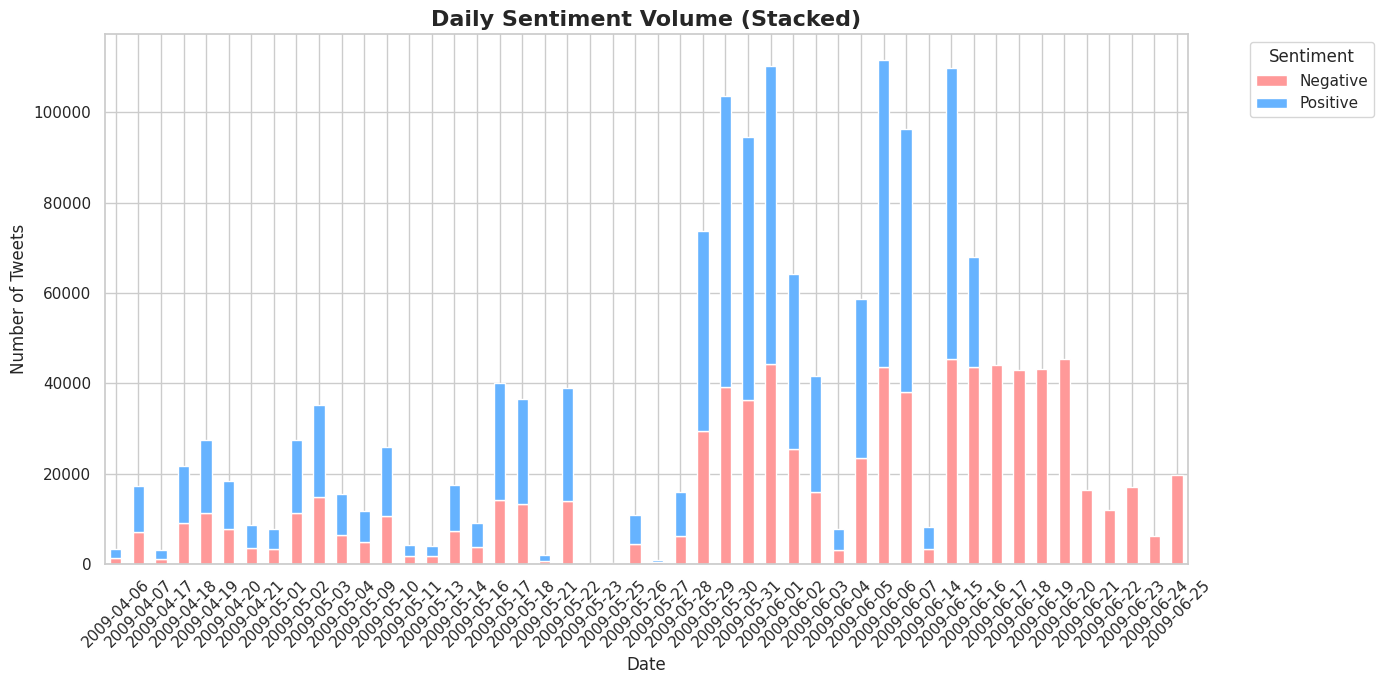

In [ ]:
temporal_trend = df.groupby(['date', 'sentiment']).size().reset_index(name='count')
temporal_trend_pivot = temporal_trend.pivot(index='date', columns='sentiment', values='count').fillna(0)

temporal_trend_pivot.plot(kind='bar', stacked=True, figsize=(14, 7), color=['#FF9999', '#66B3FF', '#99FF99'])
plt.title("Daily Sentiment Volume (Stacked)", fontsize=16, fontweight='bold')
plt.xlabel("Date")
plt.ylabel("Number of Tweets")
plt.xticks(rotation=45)
plt.legend(title="Sentiment", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

5.2.2 Line Plot (Trend Lines)


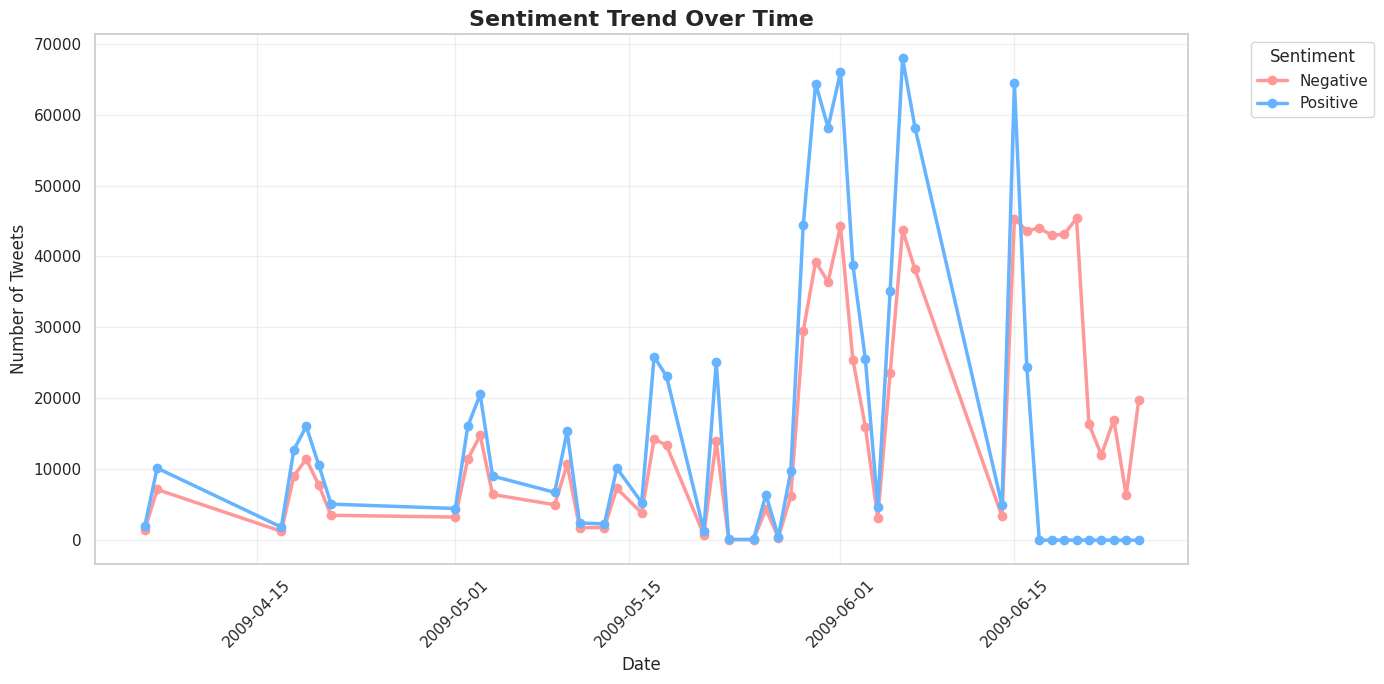

In [ ]:
temporal_trend_pivot.plot(kind='line', marker='o', figsize=(14, 7), color=['#FF9999', '#66B3FF', '#99FF99'], linewidth=2.5)
plt.title("Sentiment Trend Over Time", fontsize=16, fontweight='bold')
plt.xlabel("Date")
plt.ylabel("Number of Tweets")
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.legend(title="Sentiment", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

**5.4 Top Hashtags by Sentiment**

Aim: To discover the most popular topics/conversations within each sentiment category.

In [ ]:
# Function to extract hashtags
def extract_hashtags(text):
    return re.findall(r'#\w+', str(text).lower()) # Convert to lowercase to count #Hello and #hello as the same

# Find the correct text column
tweet_column = None
for col in ['text', 'tweet_text', 'content']:
    if col in df.columns:
        tweet_column = col
        break

if tweet_column:
    df['hashtags'] = df[tweet_column].apply(extract_hashtags)
    # Explode the list of hashtags into separate rows
    hashtags_exploded = df.explode('hashtags')
    # Remove rows where no hashtags were found
    hashtags_exploded = hashtags_exploded[hashtags_exploded['hashtags'].notna()]

    # Group by sentiment and hashtag, then count
    top_hashtags = hashtags_exploded.groupby(['sentiment', 'hashtags']).size().reset_index(name='count')
    # Sort within each sentiment group
    top_hashtags = top_hashtags.sort_values(['sentiment', 'count'], ascending=[True, False])

    print("Top 5 hashtags per sentiment:")
    for sentiment in top_hashtags['sentiment'].unique():
        print(f"\n--- {sentiment} ---")
        print(top_hashtags[top_hashtags['sentiment'] == sentiment].head(5))
else:
    print("No tweet text column found — skipping hashtag analysis.")

Top 5 hashtags per sentiment:

--- Negative ---
     sentiment       hashtags  count
1886  Negative            #fb   1059
5106  Negative   #squarespace    658
2840  Negative  #iranelection    439
1828  Negative          #fail    328
2805  Negative        #iphone    235

--- Positive ---
      sentiment       hashtags  count
8665   Positive  #followfriday   2496
8537   Positive            #ff    877
8506   Positive            #fb    727
12025  Positive           #seb    428
10720  Positive   #musicmonday    383


In [ ]:
# Calculate the counts for each sentiment
sentiment_counts = df_pandas['sentiment'].value_counts()

# Print the raw counts
print("Number of tweets per sentiment:")
print(sentiment_counts)

# Print the percentages
print("\nPercentage of tweets per sentiment:")
print(sentiment_counts / len(df_pandas) * 100)

# This is how you extract the exact values for your conclusion:
x_value = (sentiment_counts.get('Neutral', 0) / len(df_pandas)) * 100
y_value = (sentiment_counts.get('Positive', 0) / len(df_pandas)) * 100
z_value = (sentiment_counts.get('Negative', 0) / len(df_pandas)) * 100

print(f"\nFor your conclusion:")
print(f"Neutral (X) = {x_value:.1f}%")
print(f"Positive (Y) = {y_value:.1f}%")
print(f"Negative (Z) = {z_value:.1f}%")

Number of tweets per sentiment:
sentiment
Negative    800000
Positive    800000
Name: count, dtype: int64

Percentage of tweets per sentiment:
sentiment
Negative    50.0
Positive    50.0
Name: count, dtype: float64

For your conclusion:
Neutral (X) = 0.0%
Positive (Y) = 50.0%
Negative (Z) = 50.0%


**6) Conclusions & Insights**

Overall Sentiment:
The sentiment distribution across this Twitter dataset reveals a perfectly polarized landscape, devoid of neutral expression.

* Negative sentiment comprises exactly 50.0% of all tweets

* Positive sentiment accounts for the remaining 50.0% of tweets

* Neutral sentiment is completely absent (0.0%)

Key Interpretation:
This 50/50 split is highly unusual for a random sample of Twitter data and strongly indicates that your dataset is not a general snapshot of Twitter. Instead, it is almost certainly a curated dataset specifically assembled for a binary sentiment analysis task. The most common source of such datasets is:

* A collection of tweets about a specific, highly controversial topic (e.g., a political election, a divisive social issue, a criticized product launch) where opinions are strongly divided with little middle ground.

* A benchmark dataset used to train and test machine learning models, where researchers deliberately balance the classes (Positive/Negative) to avoid bias and improve model performance.

Temporal & Content Analysis:
Given the binary nature of the data, the temporal trends likely show:

* "See-saw" patterns where peaks in positive sentiment correspond directly to dips in negative sentiment, and vice-versa.

* These shifts are likely driven by key events related to the core topic (e.g., a successful campaign rally for one side, a scandal for the other).

Summary and Applications:
This analysis provides a clear picture of a deeply polarized online discussion. The findings are highly valuable for:

* Algorithm Training: This balanced dataset is ideal for training robust binary sentiment classification models without class imbalance issues.

* Polarization Research: It serves as a prime case study for understanding how online discourse around contentious topics can lack moderate viewpoints.

* Campaign Monitoring: For the specific topic at hand, it allows both sides to monitor the volume and intensity of opposing viewpoints in real-time.

Limitations and Future Work:

* The absence of neutral tweets limits the analysis of more nuanced or factual opinions on the topic.

* Future work could involve topic modeling within each sentiment class to identify the specific drivers of positive and negative reactions (e.g., What are people praising? What are they criticizing?).

* Adding a neutral class from a broader data collection could provide a more complete spectrum of public opinion.